# Projeto Final - T319 (2S2022)

### Instruções

1. Quando você terminar os exercícios do projeto, vá até o menu do Jupyter ou Colab e selecione a opção para fazer download do notebook.
    * Os notebooks tem extensão .ipynb. 
    * Este deve ser o arquivo que você irá entregar.
    * No Jupyter vá até a opção **File** -> **Download as** -> **Notebook (.ipynb)**.
    * No Colab vá até a opção **File** -> **Download .ipynb**.
2. Após o download do notebook, vá até a aba de tarefas do MS Teams, localize a tarefa referente a este projeto e faça o upload do seu notebook. Veja que há uma opção de anexar arquivos à tarefa.
3. Atente-se ao prazo de entrega definido na tarefa do MS Teams. Entregas fora do prazo não serão aceitas.
4. **O projeto pode ser resolvido em grupos de no MÁXIMO 3 alunos**.
5. Todas as questões têm o mesmo peso.
6. Não se esqueça de colocar seu(s) nome(s) e número(s) de matrícula no campo abaixo. Coloque os nomes dos integrantes do grupo no campo de texto abaixo.
7. Você pode consultar todo o material de aula.
8. A interpretação faz parte do projeto. Leia o enunciado de cada questão atentamente!
9. Boa sorte!

**Nomes e matrículas**:

1. Nome do primeiro aluno - Matrícula do primeiro aluno
2. Nome do segundo aluno - Matrícula do segundo aluno
3. Nome do terceiro aluno - Matrícula do terceiro aluno

### 1) Exercício sobre gradiente descendente estocástico

Neste exercício, você irá utilizar uma técnica de pré-processamento para escalonar os conjuntos de dados de treinamento e validação e um esquema de redução do passo de aprendizagem para melhorar o desempenho do gradiente descendente estocástico.

A função objetivo é dada por

$$y = 0.125x_1 + x_2,$$

onde $x_1$ e $x_2$ são atributos retirados de distribuições Gaussianas com médias iguais a zero e desvios padrão iguais a 8 e 1, respectivamente e $a_1 = 0.125$ e $a_2 = 1.0$.

A função observável (i.e., ruidosa) é dada por

$$y_{noisy} = y + w,$$

onde $w$ é o ruído Gaussiano branco (i.e., média zero e variância unitária) adicionado às amostras da função objetivo.

1. Execute a célula de código abaixo para definir algumas funções que serão úteis ao longo da resolução deste exercício.

In [1]:
def calculateErrorSurface(X, y, a1_min=-12.0, a1_max=14.0, a2_min=-12.0, a2_max=14.0):
    '''Generate data points for plotting the error surface.'''
    
    # Retrieve attribute vectors.
    x1 = X[:,0].reshape(X.shape[0],1)
    x2 = X[:,1].reshape(X.shape[0],1)

    # Generate values for parameter space.
    M = 200
    a1 = np.linspace(a1_min, a1_max, M)
    a2 = np.linspace(a2_min, a2_max, M)

    A1, A2 = np.meshgrid(a1, a2)

    # Generate points for plotting the cost-function surface.
    J = np.zeros((M,M))
    for iter1 in range(0, M):
        for iter2 in range(0, M):
            yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
            J[iter1, iter2] = (1.0/len(y))*np.sum(np.square(y - yhat))           
            
    return J, A1, A2

def stepDecay(alpha_init, beta, t, drop=0.5):
    '''Gradual decay.'''
    return alpha_init * math.pow(drop, math.floor((1+t)/beta))

def exponentialDecay(alpha_init, beta, t):
    '''Exponential decay.'''
    return alpha_init * np.exp(-beta*t)

def timeBasedDecay(alpha_init, beta, t):
    '''Temporal decay.'''
    return alpha_init / (1.0 + beta*t)

def learningSchedule(typels, alpha_init, beta, t):
    '''Choose among some learning schedule implementations.'''
    if(typels=='exp'):
        alpha = exponentialDecay(alpha_init, beta, t)
    elif(typels=='time'):
        alpha = timeBasedDecay(alpha_init, beta, t)
    elif(typels=='step'):
        alpha = stepDecay(alpha_init, beta, t)
    else:
        alpha = alpha_init
    return alpha

# Gradiente descendente estocástico.
def stochasticGradientDescent(X_train, y_train, X_test, y_test, n_epochs, alpha_init, beta=1.0, lrschedule='None', seed=42):
    '''Function implementing the stochastic version of the gradient descent with learning rate schedule.'''

    # Reset the PN sequence generator.
    random.seed(seed)
    
    # Number of training samples.
    N_train = X_train.shape[0]
    
    # Number of test samples.
    N_test = X_test.shape[0]
    
    # Number of attributes.
    N_att = X_train.shape[1]
    
    # Initialization of weights.
    a = np.array([-10.0, -10.0]).reshape(N_att, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((N_att, n_epochs*N_train+1))
    # Initialize history vector.
    a_hist[:, 0] = a.reshape(N_att,)

    # Create vector to store eta history.
    alpha_hist = np.zeros((n_epochs*N_train))

    # Create arrays for storing error values.
    J_train = np.zeros(n_epochs*N_train+1)
    J_test = np.zeros(n_epochs*N_train+1)

    # Calculate initial errors.
    J_train[0] = (1.0/N_train)*sum(np.power(y_train - X_train.dot(a), 2))
    J_test[0] = (1.0/N_test)*sum(np.power(y_test - X_test.dot(a), 2))

    # Initialization of history vectors.
    update_hist = np.zeros((N_att, n_epochs*N_train))
    gradient_hist = np.zeros((N_att, n_epochs*N_train))

    # Stocastic gradient-descent loop.
    iteration = 0
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_data_set_indexes = random.sample(range(0, N_train), N_train)    

        for i in range(N_train):
            # Select ONE pair sample/label from the dataset.
            random_index = shuffled_data_set_indexes[i]
            xi = X_train[random_index:random_index+1]
            yi = y_train[random_index:random_index+1]

            # Select the learning rate.
            alpha = learningSchedule(lrschedule, alpha_init, beta, epoch*N_train + i)

            # Update the weights.
            gradient = -2.0*xi.T.dot(yi - xi.dot(a))
            update = alpha*gradient
            a = a - update

            # Store current values.
            a_hist[:, epoch*N_train+i+1] = a.reshape(N_att,)
            alpha_hist[epoch*N_train+i] = alpha
            update_hist[:, epoch*N_train+i] = update.reshape(N_att,)
            gradient_hist[:, epoch*N_train+i] = gradient.reshape(N_att,)

            # Calculate errors for current iteration.
            J_train[epoch*N_train+i+1] = (1.0/N_train)*sum(np.power((y_train - X_train.dot(a)), 2))
            J_test[epoch*N_train+i+1] = (1.0/N_test)*sum(np.power((y_test - X_test.dot(a)), 2))
            
            # Increment the iteration number.
            iteration = epoch*N_train+i
            
    return a, J_train, J_test, a_hist, alpha_hist, update_hist, gradient_hist, iteration

2. Execute a célula de código abaixo para gerar os conjuntos de dados de treinamento e validação.

**DICAS**

+ Veja que 70% dos dados formam o conjunto de treinamento e os 30% restantes formam o conjunto de validação.

In [2]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Always reset the pseudo random number generator to the same number.
seed = 42
np.random.seed(seed)
random.seed(seed)

# Define the number of examples.
N = 2000

# Features.
x1 = 8.0*np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate the target function.
y = 0.125*x1 + x2

# Generate the observable function.
y_noisy = y + w

# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Split the dataset into training and validation sets.
X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=0.3, random_state=seed)

print('Tamanho do conjunto de treinamento:', len(y_train))
print('Tamanho do conjunto de validação:', len(y_test))

Tamanho do conjunto de treinamento: 1400
Tamanho do conjunto de validação: 600


3. Usando a equação normal, encontre a solução ótima para este problema de regressão, ou seja, encontre os valores de $a_1$ e $a_2$. Na sequência, imprima os valores dos pesos, calcule e imprima o erro quadrático médio (MSE) com os conjuntos de treinamento e validação.

**DICAS**

+ Para que o restante dos itens deste exercício não deem erro, nomeie a variável com os pesos ótimos de `a_opt`.

In [3]:
# Digite o código do exercício aqui.

4. Execute a célula de código abaixo e analise as duas figuras geradas. A figura da esquerda mostra a superfície de erro e a da direita a superfície de contorno, com a estrela vermelha marcando o ponto da solução ótima.

NameError: name 'a_opt' is not defined

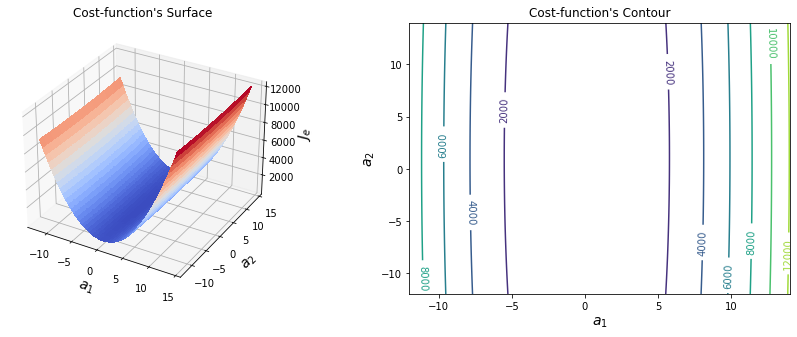

In [4]:
# Calculate the values for plotting the error surface.
J, A1, A2 = calculateErrorSurface(X_train, y_train)

# Plot cost-function surface.
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1, projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')

plt.subplot(1, 2, 2)
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-10, 14, step=2.0))
plt.yticks(np.arange(-10, 14, step=2.0))

#Show the plot.
plt.show()

5. Após observar as figuras das superfícies de erro e de contorno mostradas acima, responda as seguintes perguntas:

+ Em qual direção (eixo dos pesos) o erro varia mais rapidamente?
+ Em qual direção o erro varia mais lentamente?
+ Por que isso acontece?
+ Em qual das duas direções (i.e., eixos dos pesos $a_1$ e $a_2$) o algoritmo do gradiente descendente se moveria mais rapidamente? Em qual direção ele se moveria mais lentamente? (**Justifique suas respostas.**)

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

6. Neste item, você irá usar o algoritmo do gradiente descendente em sua versão estocástica (GDE), ou seja, a versão que utiliza apenas uma única amostra para realizar a atualização dos pesos do modelo, para resolver o problema de regressão proposto neste exercício. Neste item, o algoritmo do gradiente descendente estocástico utiliza um passo de aprendizagem fixo, ou seja, ele é constanto ao longo de todas as iterações de treinamento. 

Execute a célula de código abaixo e analise as três figuras geradas. A figura da esquerda mostra a superfície de contorno com o histórico de atualizações dos pesos (onde a estrela vermelha identifica a posição do ponto de mínimo global da superfície), a figura do meio mostra a evolução dos erros obtidos com os conjuntos de treinamento e validação ao longo das iterações de treinamento do modelo e a figura da direita mostra a evolução do termo de atualização dos pesos $a_1$ e $a_2$ em função das iterações de treinamento do modelo.

**OBS**.: A figura da direita mostra a evolução do termo de atualização dos pesos $a_1$ e $a_2$, ou seja, a figura mostra $ \alpha \times \nabla_{J_e} $, o passo de aprendizagem $\alpha$ vezes o vetor gradiente, $\nabla_{J_e}$.

NameError: name 'a_opt' is not defined

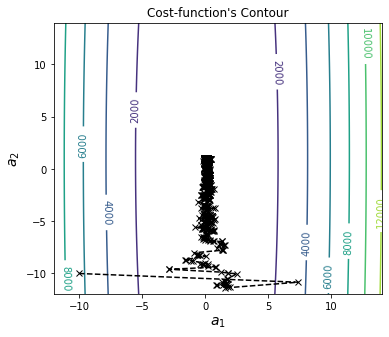

In [5]:
# Number of epochs.
n_epochs = 1

# Constant learning rate.
alpha_init = 0.003

# Gradient-descent solution.
a, J_train, J_test, a_hist, alpha_hist, update_hist, gradient_hist, iteration = stochasticGradientDescent(X_train, y_train, X_test, y_test, n_epochs, alpha_init)

# Plot figures.        
fig = plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-10, 14, step=2.0))
plt.yticks(np.arange(-10, 14, step=2.0))

plt.subplot(1, 3, 2)
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), J_train[0:n_epochs*X_train.shape[0]], label='Train')
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), J_test[0:n_epochs*X_train.shape[0]], label='Test')
plt.xlim((0, n_epochs*X_train.shape[0]))
plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), update_hist[0,:], label='$a_1$')
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), update_hist[1,:], label='$a_2$')
plt.ylim([-2, 2])
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\\nabla_{J_e}$', fontsize=14)
plt.title('Update vs. Iteration number')
plt.grid()
plt.legend()

plt.show()

# Print found weights.
print('----- Eq. Normal -----')
print('a1 (ótimo): ' + str(a_opt[0, 0]))
print('a2 (ótimo): ' + str(a_opt[1, 0]))
# Print the MSE.
y_pred_train = X_train.dot(a_opt)
y_pred_test = X_test.dot(a_opt)
print('MSE de treinamento (ótimo):', mean_squared_error(y_train, y_pred_train))
print('MSE de validação (ótimo):', mean_squared_error(y_test, y_pred_test))
print('')

# Print found weights.
print('-------- GDE --------')
print('a1 (GDE): ' + str(a[0, 0]))
print('a2 (GDE): ' + str(a[1, 0]))
# Print the MSE.
y_pred_train = X_train.dot(a)
y_pred_test = X_test.dot(a)
print('MSE de treinamento (GDE):', mean_squared_error(y_train, y_pred_train))
print('MSE de validação (GDE):', mean_squared_error(y_test, y_pred_test))
print('')

7. Após observar as figuras da superfície de contorno, de evolução do erro e de evolução do gradiente mostradas acima, responda as seguintes perguntas:

+ O algoritmo do gradiente descendente se aproxima rapidamente do ponto de mínimo global?
+ Se a movimentação em direção ao ponto de mínimo global não for rápida, qual é o motivo para isto? 
+ Observando as três figuras, o que pode-se dizer sobre a convergência do algoritmo do gradiente descendente estocástico?
+ O que pode ser feito para acelerar a movimentação do algoritmo em direção ao ponto de mínimo global?

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

8. Realize a **padronização** dos atributos dos conjuntos de treinamento e de validação e, na sequência, encontre a solução ótima com a equação normal e imprima os novos pesos e os erros de treinamento e validação.

**DICAS**

+ Lembre-se que os parâmetros de padronização (média e variância) são calculados com o conjunto de treinamento e aplicados na padronização do conjunto de validação, ou seja, não se calcula os parâmetros de padronização para o conjunto de validação, apenas se utiliza os parâmetros calculados com o conjunto de treinamento.
+ A classe `StandardScaler` já foi importada no item 1 do exercício, você só precisa instanciar um objeto do classe e realizar a padronização dos atributos.

In [ ]:
# Digite o código do exercício aqui.

9. Após ter realizado a padronização dos atributos, responda as seguintes perguntas:

+ Os valores ótimos dos pesos são semelhantes daos encontrados no item 3 deste exercício? 
+ Caso não sejam, explique o motivo para a diferença.

**DICAS**

+ Perceba que os valores normalizados dos atributos são usados novamente para o cálculo do ponto ótimo.

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

10. Neste item, você irá usar o algoritmo do gradiente descendente estocástico (GDE) e os atributos **padronizados** para resolver o problema de regressão proposto neste exercício. Neste item, o algoritmo do gradiente descendente estocástico utiliza um passo de aprendizagem fixo, ou seja, ele é constanto ao longo de todas as iterações de treinamento. 

Execute a célula abaixo e analise as três figuras geradas. A figura da esquerda mostra a superfície de contorno com o histórico de atualizações dos pesos (onde a estrela vermelha identifica a posição do ponto de mínimo global da superfície), a figura do meio mostra a evolução dos erros obtidos com os conjuntos de treinamento e validação ao longo das iterações de treinamento do modelo e a figura da direita mostra a evolução do termo de atualização dos pesos $a_1$ e $a_2$ em função das iterações de treinamento do modelo.

**OBS**.: A figura da direita mostra a evolução do termo de atualização dos pesos $a_1$ e $a_2$, ou seja, a figura mostra $ \alpha \times \nabla_{J_e} $, o passo de aprendizagem $\alpha$ vezes o vetor gradiente, $\nabla_{J_e}$.

C:\Users\FELIPE~1.FIG\AppData\Local\Temp/ipykernel_20372/3302915802.py:115: RuntimeWarning: overflow encountered in add
  J_train[epoch*N_train+i+1] = (1.0/N_train)*sum(np.power((y_train - X_train.dot(a)), 2))
C:\Users\FELIPE~1.FIG\AppData\Local\Temp/ipykernel_20372/3302915802.py:116: RuntimeWarning: overflow encountered in add
  J_test[epoch*N_train+i+1] = (1.0/N_test)*sum(np.power((y_test - X_test.dot(a)), 2))
C:\Users\FELIPE~1.FIG\AppData\Local\Temp/ipykernel_20372/3302915802.py:115: RuntimeWarning: overflow encountered in power
  J_train[epoch*N_train+i+1] = (1.0/N_train)*sum(np.power((y_train - X_train.dot(a)), 2))
C:\Users\FELIPE~1.FIG\AppData\Local\Temp/ipykernel_20372/3302915802.py:116: RuntimeWarning: overflow encountered in power
  J_test[epoch*N_train+i+1] = (1.0/N_test)*sum(np.power((y_test - X_test.dot(a)), 2))
C:\Users\FELIPE~1.FIG\AppData\Local\Temp/ipykernel_20372/3302915802.py:104: RuntimeWarning: overflow encountered in multiply
  gradient = -2.0*xi.T.dot(yi - xi.dot(

NameError: name 'a_opt' is not defined

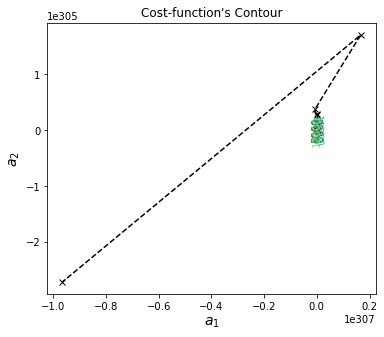

In [6]:
# Number of epochs.
n_epochs = 1

# Constant learning rate.
alpha_init = 0.1

# Gradient-descent solution.
a, J_train, J_test, a_hist, alpha_hist, update_hist, gradient_hist, iteration = stochasticGradientDescent(X_train, y_train, X_test, y_test, n_epochs, alpha_init)

# Calculate the values for plotting the error surface.
J, A1, A2 = calculateErrorSurface(X_train, y_train)

# Plot figures.        
fig = plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-10, 14, step=2.0))
plt.yticks(np.arange(-10, 14, step=2.0))

plt.subplot(1, 3, 2)
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), J_train[0:n_epochs*X_train.shape[0]], label='Train')
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), J_test[0:n_epochs*X_train.shape[0]], label='Test')
plt.xlim((0, n_epochs*X_train.shape[0]))
plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), update_hist[0,:], label='$a_1$')
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), update_hist[1,:], label='$a_2$')
plt.ylim([-2, 2])
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\\nabla_{J_e}$', fontsize=14)
plt.title('Update vs. Iteration number')
plt.grid()
plt.legend()

plt.show()

# Print found weights.
print('----- Eq. Normal -----')
print('a1 (ótimo): ' + str(a_opt[0, 0]))
print('a2 (ótimo): ' + str(a_opt[1, 0]))
# Print the MSE.
y_pred_train = X_train.dot(a_opt)
y_pred_test = X_test.dot(a_opt)
print('MSE de treinamento (ótimo):', mean_squared_error(y_train, y_pred_train))
print('MSE de validação (ótimo):', mean_squared_error(y_test, y_pred_test))
print('')

# Print found weights.
print('-------- GDE --------')
print('a1 (GDE): ' + str(a[0, 0]))
print('a2 (GDE): ' + str(a[1, 0]))
# Print the MSE.
y_pred_train = X_train.dot(a)
y_pred_test = X_test.dot(a)
print('MSE de treinamento (GDE):', mean_squared_error(y_train, y_pred_train))
print('MSE de validação (GDE):', mean_squared_error(y_test, y_pred_test))
print('')

11. Após observar as figuras da superfície de contorno, de evolução do erro e de evolução do gradiente mostradas acima, responda as seguintes perguntas:

+ O algoritmo do gradiente descendente se aproxima rapidamente do ponto de mínimo global?
+ Se a movimentação em direção ao ponto de mínimo global for rápida, qual é o motivo para isto? 
+ Observando as três figuras, o que pode-se dizer sobre a convergência do algoritmo do gradiente descendente estocástico? 
+ Houve alguma melhoria em relação à convergência do algoritmo após a padronização?

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

12. Neste item, vamos utilizar o esquema de redução gradual do passo de aprendizagem para melhorar a convergência do gradiente descendente estocástico. O objetivo deste item é encontrar o valor de `beta`, ou seja, o número de iterações necessárias para que o passo de aprendizado seja reduzido, de tal forma que o algoritmo do gradiente descendente estocástico se estabilize ao redor do ponto de mínimo global.

**DICAS**

+ Altere o valor da variável `beta` na célula de código abaixo de 6 até 17, em passos de 1 unidade. Para cada novo valor de `beta`, execute a célula de código abaixo e analise as figuras e valores gerados.
+ Altere apenas o valor da variável `beta`.

**OBS**.: A terceira figura mostra a evolução do termo de atualização dos pesos $a_1$ e $a_2$, ou seja, a figura mostra $\alpha \times \nabla_{J_e} $, o passo de aprendizagem $\alpha$ vezes o vetor gradiente, $\nabla_{J_e}$.

NameError: name 'a_opt' is not defined

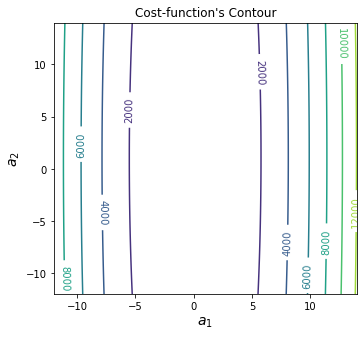

In [7]:
# Number of epochs.
n_epochs = 1

lrschedule = 'step' # sem o uso de nenhuma abordagem de redução do passo de aprendizagem.

# Constant learning rate.
alpha_init = 0.1

# Decaying step.
beta = 6

# Gradient-descent solution.
a, J_train, J_test, a_hist, alpha_hist, update_hist, gradient_hist, iteration = stochasticGradientDescent(X_train, y_train, X_test, y_test, n_epochs, alpha_init, beta, lrschedule, seed)

# Calculate the values for plotting the error surface.
J, A1, A2 = calculateErrorSurface(X_train, y_train)

# Plot figures.        
fig = plt.figure(figsize=(25,5))

plt.subplot(1, 4, 1)
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-10, 12, step=2.0))
plt.yticks(np.arange(-10, 12, step=2.0))

plt.subplot(1, 4, 2)
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), J_train[0:n_epochs*X_train.shape[0]], label='Train')
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), J_test[0:n_epochs*X_train.shape[0]], label='Test')
plt.xlim((0, n_epochs*X_train.shape[0]))
plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.grid()
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), update_hist[0,:], label='$a_1$')
plt.plot(np.arange(0, n_epochs*X_train.shape[0]), update_hist[1,:], label='$a_2$')
plt.ylim([-2, 2])
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\\nabla_{J_e}$', fontsize=14)
plt.title('Update vs. Iteration number')
plt.grid()
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(range(0,n_epochs*X_train.shape[0]), alpha_hist)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Iteração', fontsize=14)
plt.ylabel('Learning step', fontsize=14)
plt.title('Variation of the learning step')

plt.show()

# Print found weights.
print('----- Eq. Normal -----')
print('a1 (ótimo): ' + str(a_opt[0, 0]))
print('a2 (ótimo): ' + str(a_opt[1, 0]))
# Print the MSE.
y_pred_train = X_train.dot(a_opt)
y_pred_test = X_test.dot(a_opt)
print('MSE de treinamento (ótimo):', mean_squared_error(y_train, y_pred_train))
print('MSE de validação (ótimo):', mean_squared_error(y_test, y_pred_test))
print('')

# Print found weights.
print('-------- GDE --------')
print('a1 (GDE): ' + str(a[0, 0]))
print('a2 (GDE): ' + str(a[1, 0]))
# Print the MSE.
y_pred_train = X_train.dot(a)
y_pred_test = X_test.dot(a)
print('MSE de treinamento (GDE):', mean_squared_error(y_train, y_pred_train))
print('MSE de validação (GDE):', mean_squared_error(y_test, y_pred_test))
print('')

13. Após ter alterado o valor da variável `beta` e analisado as figuras e valores gerados no item anterior, responda:

+ Qual valor de `beta` faz com que o GDE tenha uma melhora em sua convergência?
+ Por que consegue-se esta melhora na convergência do GDE?
+ O decaimento gradual do passo de aprendizagem tem alguma influência na direção com que o GDE caminha para o ponto de mínimo?

**DICAS**

+ Para responder a terceira pergunta acima, compare a figura da superfície de contorno com o histórico de atualizações dos pesos do item 10 com a mesma figura do item 12. Compare o caminho feito pelo GDE nas duas figuras.

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

### 2) Exercício sobre regressão polinomial para aproximação de FDPs desconhecidas.

Em telecomunicações, podemos encontrar, em determinados problemas, variáveis aleatórias que não possuem formas conhecidas para suas funções densidade de probabilidade (FDP). Nestes casos, podemos recorrer à aproximação de funções como uma forma de encontrar uma função que aproxime os valores observados desta variável aleatória. Portanto, neste exercício, iremos usar regressão polinomial para encontrar uma função que aproxime os dados observados de uma variável aleatória o melhor possível.

1. As observações da variável aleatória com FDP desconhecida podem ser geradas com o trecho de código abaixo. Portanto, execute código abaixo e analise o resultado.

**DICAS**

+ Este exercício consume muita memória RAM, portanto, para que você não encontre problemas durante sua execução, execute este exercício no Google Colab.

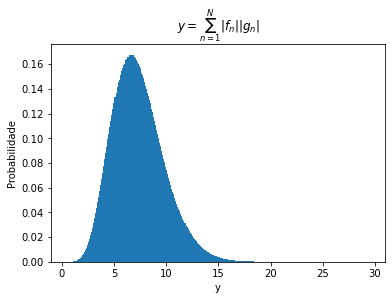

In [1]:
# Importa bibliotecas necessárias.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Reseta gerador de sequências pseudo-aleatórias.
seed = 42
np.random.seed(seed)

# Número de amostras da variável aleatória.
M = 10000000

# Número de termos do somatório.
N = 4

# Gera uma das variáveis aleatórias.
f = 1.1 + (1/(np.sqrt(2)))*(np.random.randn(N,M) + 1j*np.random.randn(N,M))
f = np.abs(f)

# Gera outra variável aleatória.
g = 1.1 + (1/(np.sqrt(2)))*(np.random.randn(N,M) + 1j*np.random.randn(N,M))
g = np.abs(g)

# Gera variável aleatória com FDP desconhecida.
h = np.sum(f*g, axis=0)

# Número de divisões do histograma.
bins = 300
y, X, p = plt.hist(h, bins=bins, density=True)
plt.title('$y = \sum_{n=1}^{N} |f_n||g_n|$')
plt.ylabel('Probabilidade')
plt.xlabel('y')
plt.show()

# Redimensionando o vetor de atributos.
X = X[0:len(X)-1].reshape(bins,1)

2. Com a matriz de atributos X e o vetor de rótulos y obtidos no item anterior, utilize a técnica de validação cruzada k-Fold para escolher a melhor ordem para o modelo de aproximação da FDP. Para isso:

 1. Use o **k-Fold** com **k** igual a 10 e o parâmetro `random_state=0`.
 2. Faça a análise de polinômios de ordem 1 até 30, **inclusive**.
 3. Inclua o atributo de bias ao instanciar a classe `PolynomialFeatures` utilizando o parâmetro `include_bias=True`.
 4. Use a classe `StandardScaler` para escalonar os dados.
 5. Plote gráficos com a média e o desvio padrão do erro quadrático médio (MSE) em função do grau do polinômio.

**DICAS** 

+ O tempo de execução desse exercício é de aproximadamente 10 minutos, mas pode variar de computador para computador, portanto, pegue um café e tenha paciência.

In [1]:
# Digite o código do exercício aqui.

3. Após analisar os resultados do item anterior, responda: Qual a melhor ordem do polinômio para esse problema? **Justifique sua resposta.**

**DICAS**

+ Use o princípio da navalha de Occam para escolher a ordem do polinômio.

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

4. De posse da melhor ordem, treine um novo modelo de regressão polinomial considerando esta ordem e no final imprima o valor do erro quadrático médio para (MSE).

**DICAS**
+ Inclua o bias ao instanciar a classe `PolynomialFeatures` utilizando o parâmetro `include_bias=True`.
+ Use a classe `StandardScaler` para normalizar os dados.
+ Use o conjunto total de amostras para calcular o erro.

In [2]:
# Digite aqui o código do exercício.

5. Apresente uma figura comparando a predição feita pelo melhor regressor polinomial com os dados originais.

In [3]:
# Digite aqui o código do exercício.

### 3) Utilizando regressão para prever o custo médio de casas.

Neste exercício, você irá utilizar validação cruzada para encontrar a ordem ideal de uma função hipótese que será usada para aproximar o conjunto de dados do Boston Housing e prever o custo médio de uma casa em uma área de Boston. O objetivo é prever o valor dos preços de casas usando os atributos fornecidos.

Esta base de dados contém informações do censo dos EUA relativos a casas em várias áreas da cidade de Boston. Cada exemplo corresponde a uma área única e possui 13 medidas. Devemos pensar em exemplos como linhas e atributos como colunas da base de dados. A base de dados do Boston Housing é um das várias bases de dados disponibilizadas pela biblioteca SciKit-Learn. 

A base de dados possui 506 exemplos (i.e. linhas) e 13 atributos numéricos (i.e., colunas). O décimo quarto atributo (i.e., **MEDV**: Median value of owner-occupied homes in USD 1000's) é considerado como sendo o rótulo, ou seja, o valor que queremos prever com o modelo. A descrição das informações contidas no banco de dados segue abaixo.

| Attribute |                              Description                              |
|:---------:|:---------------------------------------------------------------------:|
|    CRIM   |                     per capita crime rate by town                     |
|     ZN    |    proportion of residential land zoned for lots over 25,000 sq.ft.   |
|   INDUS   |            proportion of non-retail business acres per town           |
|    CHAS   | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
|    NOX    |           nitric oxides concentration (parts per 10 million)          |
|     RM    |                  average number of rooms per dwelling                 |
|    AGE    |         proportion of owner-occupied units built prior to 1940        |
|    DIS    |          weighted distances to five Boston employment centres         |
|    RAD    |               index of accessibility to radial highways               |
|    TAX    |                full-value property-tax rate per USD 10.000               |
|  PTRATIO  |                      pupil-teacher ratio by town                      |
|     B     |  1000(Bk - 0.63)^2 where Bk is the proportion of black people by town |
|   LSTAT   |                     lower status of the population                    |
|    MEDV   |            Median value of owner-occupied homes in USD 1000's            |

1. Execute a célula abaixo para importar o conjunto de dados.

In [37]:
# importing libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_boston

# Reset PN sequence generator.
seed = 42
np.random.seed(seed)

# Load the dataset.
dataset = load_boston()

2. Na sequência, faremos uma análise exploratória simplificada dos dados para escolhermos quais são os melhores atributos para serem usados para a aproximação do preço médio dado pelo atributo **MEDV**. 

+ No trecho de código abaixo, para facilitar o processamento dos dados, transformamos a base de dados em um objeto do tipo `DataFrame` da biblioteca `pandas`, em seguida, criamos uma matriz de correlação que mede as relações lineares entre os atributos, incluindo o rótulo. A matriz de correlação é criada usando-se a função `corr` da biblioteca `pandas`. 
+ Usamos a função `heatmap` (mapa de calor) da biblioteca `seaborn` para plotar a matriz de correlação.
+ A matriz de correlação vai nos ajudar a entender a relação do rótulo com os atributos.

Execute o trecho de código abaixo e analise a matriz de correlação.

<AxesSubplot:>

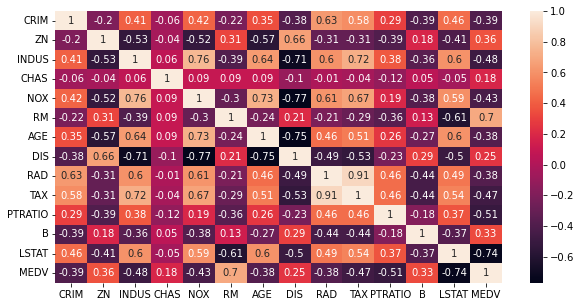

In [38]:
# Import the necessary libraries.
import pandas as pd
import seaborn as sns

# Load the data into a pandas dataframe using pd.DataFrame.
boston = pd.DataFrame(dataset.data, columns=dataset.feature_names)

# Create a new column of target values and add it to the dataframe.
boston['MEDV'] = dataset.target

# Create a correlation matrix
correlation_matrix = boston.corr().round(2)
# Plot the correlation matrix.
plt.figure(figsize=(10,5))
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

3. Agora, baseado em nossa análise da matriz de correlação, iremos escolher **2** atributos que têm maior correlação com o objetivo, ou seja, o rótulo **MEDV**. Seguem algumas dicas de como essa escolha deve ser feita:

+ Os coeficientes de correlação (ou seja, os valores mostrados na matriz de correlação) variam de -1 a 1. Se o valor for próximo a 1, significa que há uma forte correlação positiva entre as duas variáveis. Quando é próximo a -1, as variáveis apresentam forte correlação negativa.
+ Cada coluna da matriz acima apresenta a correlação entre um atribito com ele mesmo e com todos os outros atributos.
+ Para treinar um modelo de regressão linear, selecionamos os atributos que têm uma alta correlação (tanto positiva quanto negativa) com nossa variável-alvo **MEDV**. Portanto, observe a última coluna da matriz de correlação.

Após observar os coeficientes de correlação da matriz, quais são os 2 atributos com maior correlação com o rótulo, **MEDV**.

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

4. Agora iremos preparar os dados para treinar o modelo de regressão. Precisamos criar uma matriz de atributos, $X$, com os 2 atributos escolhidos e o vetor de rótulos, $y$, com os valores de **MEDV**.

**DICAS**

+ Para concatenar os colunas dos atributos escolhidos, usamos `np.c_` fornecido pela biblioteca numpy. Segue um exemplo de uso:
```python
N = 10
x1 = np.random.rand(N,1) # vetor coluna com N linhas e 1 coluna
x2 = np.random.rand(N,1) # vetor coluna com N linhas e 1 coluna
X = np.c_[x1,x2]
```
+ A matriz de atributos, $X$, resultante deve ter 506 linhas por 2 coluna. O vetor de rótulos, $y$, deve ter uma única dimensão, com 506 valores. Imprima as dimensões dos dois vetores com o atributo `shape`.
+ As colunas com os valores dos atributos escolhidos podem ser obtidas a partir do objeto `boston` (que é do tipo `DataFrame` da biblioteca `pandas`) da mesma forma que acessamos valores de um dicionário Python, ou seja, utilizamos a `chave`, que no caso é o nome do atributo, para obtermos a coluna de valores associados àquele atributo. A mesma coisa deve ser feita para o rótulo, o qual foi concatenado ao objeto `boston` para que conseguíssemos criar a matriz de correlação. Veja o exemplo abaixo que obtem a coluna de valores referentes ao rótulo `MEDV`:
```python
y = boston['MEDV']
```

Portanto, crie na célula abaixo a matriz de atributos `X` e o vetor de rótulos $y$. Não se esqueça de imprimir as dimensões da matriz e do vetor.

In [4]:
# Digite o código do exercício aqui.

5. Usando a estratégia de validação cruzada conhecida como **k-Fold**, encontre a ordem ideal para que uma função hipótese polinomial aproxime bem o conjunto de dados. Para avaliar qual é a ordem ideal para o polinômio aproximador, plote as curvas da média do erro quadrático médio (MSE) versus a ordem do polinômio e do desvio padrão versus a ordem do polinômio.

**DICAS**

+ Use o **k-Fold** com **k** igual a 5.
+ Configure o parâmetro `shuffle` da classe `KFold` como `True`, ou seja, `shuffle=True`.
+ Analise polinômios com ordens variando de 1 até 6, **inclusive**.
+ Configure o parâmetro `include_bias` da classe `PolynomialFeatures` para `True`, ou seja, `include_bias=True`.
+ Use a classe `StandardScaler` para normalizar os dados.
+ Plote gráficos com a média e o desvio padrão do erro quadrático médio (MSE) em função do grau do polinômio.
+ Use escala logarítmica para plotar os gráficos. Isso pode ser feito usando-se a função `yscale` da biblioteca matplotlib:
```python
plt.yscale('log')
```

In [5]:
# Digite o código do exercício aqui.

6. Após analisar os resultados obtidos com a estratégia de validação cruzada do **k-Fold**, reponda qual é a melhor ordem de polinômio para aproximar os dados. **Justifique sua resposta.**

**DICAS**

* Lembre-se do princípio da navalha de Occam para escolher a melhor ordem.
* Comente sobre a flexibilidade e grau de generalização do modelo escolhido.

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

7. Em seguida, de posse da melhor ordem de polinômio que aproxima os dados observados, faça:

+ Treine um modelo de regressão polinomial com a ordem escolhida, 
+ Realize predições (ou seja, use o modelo treinado para **predizer** os valores de $y$ com os valores de $X$.) com todos os dados observados, ou seja, $X$.
+ Imprima o erro quadrático médio, **MSE**, entre a predição e os valores esperados, ou seja, o vetor $y$.

**DICAS:**

* Utilize **padronização de atributos** com a classe `StandardScaler` da biblioteca SciKit-Learn.
* Crie uma sequência de ações (`PolynomialFeatures`, `StandardScaler` e `LinearRegression`) utilizando a classe `Pipeline` da biblioteca SciKit-Learn para realizar a regressão.
+ Configure o parâmetro `include_bias` da classe `PolynomialFeatures` para `True`, ou seja, `include_bias=True`.
+ Para calcular o erro quadrático médio, **MSE**, entre a predição e os valores esperados use a função `mean_squared_error` do módulo `sklearn.metrics`. Note que ela já foi importada, então, apenas a invoque.

In [6]:
# Digite o código do exercício aqui.

8. E se acrescentássemos um terceiro atributo à matriz de atributos $X$, o erro quadrático médio seria menor?

**DICAS**

+ Volte ao item onde plotamos a matriz de correlação e encontre um terceiro atributo que possui um coeficiente de correlação (positivo ou negativo) alto.
+ A matriz de atributos, $X$, resultante deve ter 506 linhas por 3 colunas. O vetor de rótulos, $y$, deve ter uma única dimensão, com 506 valores. Imprima as dimensões dos dois vetores com o atributo `shape`.

Portanto, crie na célula abaixo a nova matriz de atributos $X$ e o vetor de rótulos $y$. Não se esqueça de imprimir as dimensões da matriz de atributos e do vetor de rótulos.

In [7]:
# Digite o código do exercício aqui.

9. Usando a estratégia de validação cruzada conhecida como **k-Fold**, encontre a ordem ideal para que uma função hipótese polinomial aproxime bem o conjunto de dados. Para avaliar qual é a ordem ideal para o polinômio aproximador, plote as curvas da média do erro quadrático médio (MSE) versus a ordem do polinômio e do desvio padrão versus a ordem do polinômio.

**DICAS**

+ Use o **k-Fold** com **k** igual a 5.
+ Configure o parâmetro `shuffle` da classe `KFold` como `True`, ou seja, `shuffle=True`.
+ Analise polinômios com ordens variando de 1 até 6, **inclusive**.
+ Configure o parâmetro `include_bias` da classe `PolynomialFeatures` para `True`, ou seja, `include_bias=True`.
+ Use a classe `StandardScaler` para normalizar os dados.
+ Plote gráficos com a média e o desvio padrão do erro quadrático médio (MSE) em função do grau do polinômio.
+ Use escala logarítmica para plotar os gráficos. Isso pode ser feito usando-se a função `yscale` da biblioteca matplotlib:
```python
plt.yscale('log')
```

In [8]:
# Digite o código do exercício aqui.

10. Em seguida, de posse da melhor ordem de polinômio que aproxima os dados observados, faça:

+ Treine um modelo de regressão polinomial com a ordem escolhida, 
+ Realize predições (ou seja, use o modelo treinado para **predizer** os valores de $y$ com os valores de $X$.) com todos os dados observados, ou seja, $X$.
+ Imprima o erro quadrático médio, **MSE**, entre a predição e os valores esperados, ou seja, o vetor $y$.

**DICAS:**

* Utilize **padronização de atributos** com a classe `StandardScaler` da biblioteca SciKit-Learn.
* Crie uma sequência de ações (`PolynomialFeatures`, `StandardScaler` e `LinearRegression`) utilizando a classe `Pipeline` da biblioteca SciKit-Learn para realizar a regressão.
+ Configure o parâmetro `include_bias` da classe `PolynomialFeatures` para `True`, ou seja, `include_bias=True`.
+ Para calcular o erro quadrático médio, **MSE**, entre a predição e os valores esperados use a função `mean_squared_error` do módulo `sklearn.metrics`. Note que ela já foi importada, então, apenas a invoque.

In [9]:
# Digite o código do exercício aqui.

11. O erro do modelo que utiliza 3 atributos é menor do que o do modelo utilizando 2 atributos? Se continuarmos aumentando o número de atributos, o erro será menor? (**Justifique suas respostas.**)

**DICAS**

+ Para responder à segunda pergunta, pense na quantidade de informação que é incorporada ao modelo quando se aumenta o número de atributos.

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

### 4) Comparando o desempenho de modelos de regressão.

Nesse exercício, você fará o treinamento de três modelos de regressão e, ao final, comparará seus desempenhos.

1. Execute a célula abaixo para importar os dados e as bibliotecas necessárias.

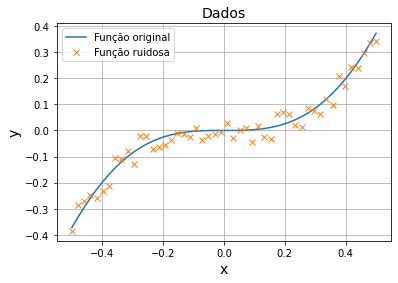

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# Reset PN sequence generator.
seed = 42
np.random.seed(seed)

# Números de amostras.
N = 50

# Dados.
x = np.linspace(-0.5, 0.5, N).reshape(N, 1)
w = 0.1*np.random.rand(N, 1) - 0.05
y = 2*x**9 - 4*x**7 + 3.2*x**3
y_noisy = y + w

# Visualização dos dados
plt.plot(x.ravel(), y.ravel(), label='Função original')
plt.plot(x.ravel(), y_noisy.ravel(), 'x', label='Função ruidosa')
plt.xlabel('x', fontsize=14) 
plt.ylabel('y', fontsize=14)
plt.title('Dados', fontsize=14)
plt.grid()
plt.legend()
plt.show()

2. Após analisar o gráfico do item anterior, responda: Uma reta teria capacidade/flexibilidade suficiente para gerar um modelo que se aproxime bem dos dados originais? Se sim, justifique. Caso sua resposta seja não, apresente uma possível alternativa para se obter um modelo que se aproxime bem dos dados originais.

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

3. Sabe-se que o modelo ideal para esses dados é obtido por meio da regressão linear com polinômio de ordem igual a 9 (veja código do item 1). Suponha que você não saiba desta informação e que você tenha escolhido um polinômio de ordem igual a 50 (perceba que é mesmo número de amostras geradas no item 1) para treinar o modelo. Qual problema você encontraria? Seu modelo iria sobreajustar ou subajustar? Como esse problema poderia ser mitigado? (**Justifique todas as respostas.**)

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

4. Neste e nos próximos dois itens, você irá treinar um total de três modelos diferentes. Treine um primeiro modelo de regressão polinomial com ordem igual a 9, calcule e imprima o erro quadrático médio e plote um gráfico comparando as funções original, ruidosa e aproximada:
 - Inclua o bias ao instanciar a classe `PolynomialFeatures` utilizando o parâmetro `include_bias=True`.
 - Padronize os dados com o uso da classe `StandardScaler`.
 - Como sempre, use um **pipeline** para sequencializar a aplicação das ações. Use um objeto da classe `Pipeline`.
 - Imprima o erro quadrático médio. O erro deve ser calculado com o **conjunto total de amostras**.
 - Ao final, plote uma figura que compare as funções original, ruidosa e aproximada.
 - Observe que o modelo treinado se aproxima bastante da função original.

In [10]:
# Digite o código do exercício aqui. (Modelo 1).

5. Treine um segundo modelo de regressão polinomial com ordem igual a 50, calcule e imprima o erro quadrático médio e plote um gráfico comparando as funções original, ruidosa e aproximada:
 - Inclua o bias ao instanciar a classe `PolynomialFeatures` utilizando o parâmetro `include_bias=True`.
 - Padronize os dados com o uso da classe `StandardScaler`.
 - Como sempre, use um **pipeline** para sequencializar a aplicação das ações. Use um objeto da classe `Pipeline`.
 - Imprima o erro quadrático médio. O erro deve ser calculado com o **conjunto total de amostras**.
 - Ao final, plote uma figura que compare as funções original, ruidosa e aproximada.
 - Verifique que está ocorrendo o fenômeno mencionado por você no item C deste exercício.

In [11]:
# Digite o código do exercício aqui. (Modelo 2).

6. Por que o erro quadrático médio (MSE) do modelo com ordem igual a 50 é menor do que o erro do modelo com ordem igual a 9? (**Justifique a sua resposta.**)

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

7. Encontre o valor ótimo do **fator de regularização**, $\lambda$, para um modelo de regressão polinomial com regularização L1, ou seja, **regressão LASSO**, com ordem igual a 50. Ao final, imprima o valor ótimo encontrado para o **fator de regularização**, $\lambda$.

**DICAS**

+ Você precisará encontrar o valor ótimo do **fator de regularização**, $\lambda$. Para isso, use um objeto da classe `LassoCV` passando para o parâmetro de entrada `alphas` (que aqui é o fator de regularização) um sequência de 10000 valores retirados de um intervalo linear entre 0.0001 e 0.001. Veja o exemplo abaixo:
```python
M = 10000
np.linspace(0.0001, 0.001, M)
```
+ Para mais informações sobre a classe `LassoCV`, acesse sua documentação através do seguinte link: [Documentação LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html).
+ Inclua o atributo de bias ao instanciar a classe `PolynomialFeatures` utilizando o parâmetro `include_bias=True`.
+ Padronize os dados com o uso da classe `StandardScaler`.
+ Como sempre, use um pipeline para sequencializar a aplicação das ações. Use um objeto da classe `Pipeline`.
+ Após o treinamento do objeto da classe `LassoCV`, o valor ótimo do **fator de regularização** pode ser acessado como mostrado abaixo. No exemplo abaixo, o objeto da classe `Pipeline` se chama `clf` e o nome dado ao objeto da classe `LassoCV` é `reg`.
```python
clf['reg'].alpha_
```

In [12]:
# Digite o código do exercício aqui.

8. De posse do valor ótimo do **fator de regularização**, treine um terceiro modelo de regressão polinomial com ordem igual a 90 e:

 - Utilize regularização L1 (use a classe `Lasso`) para aproximar o modelo 1.
 - Instancie um objeto da classe `Lasso` com o valor ótimo do **fator de regularização** encontrado no item anterior.
 - Inclua o atributo de bias ao instanciar a classe `PolynomialFeatures` utilizando o parâmetro `include_bias=True`.
 - Padronize os dados com o uso da classe `StandardScaler`.
 - Como sempre, use um pipeline para sequencializar a aplicação das ações. Use um objeto da classe `Pipeline`.
 - Imprima o erro quadrático médio. O erro deve ser calculado com o conjunto total de amostras.
 - Ao final, plote uma figura que compare as funções original, ruidosa e aproximada.
 - Analise o resultado mostrado na figura.

In [13]:
# Digite o código do exercício aqui. (Modelo 3).

9. Após o treinamento do regressor LASSO do item anterior, imprima os pesos associados aos atributos.

**DICAS**

+ Os pesos associados aos atributos podem ser acessados como mostrado abaixo. No exemplo abaixo, o objeto da classe `Pipeline` se chama `clf` e o nome dado ao objeto da classe `Lasso` é `reg`.
```python
clf['reg'].coef_
```

In [14]:
# Digite o código do exercício aqui.

10. De posse do resultado do item anterior, responda as seguintes perguntas:

+ Quantos pesos são diferentes de zero?
+ O que aconteceu aqui para que vários dos pesos tenham se tornando iguais a zeros?
+ O que indica um peso ter seu valor igual a zero?
+ Seria possível usarmos um modelo apenas com os pesos diferentes de zero mostrados no item anterior? (**Justifique sua resposta.**)
+ Qual vantagem esse novo modelo teria sobre o modelo com todos os pesos, ou seja, o modelo que inclui também os pesos iguais a zero? (**Justifique sua resposta.**)

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**

11. Plote as funções original, ruidosa e as aproximações obtidas com os modelos 1, 2 e 3.

**DICAS**

+ Use cores diferentes para cada função.

In [15]:
# Digite o código do exercício aqui. 

12. Após analisar a figura do item anterior, responda:

+ O modelo 3 (modelo utilizando regressão LASSO) se aproximou do modelo ideal (modelo com a mesma complexidade da função original), ou seja, do modelo 1? (Justifique sua resposta).
+ O que você pode concluir a respeito do uso da regularização para modelos com ordem desconhecida?

<span style="color:blue">Digite aqui a resposta do exercício.</span>

**Resposta**